In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

turbo = pd.read_csv("../campaign/turbo-v1.0.1.csv")

# Fix a slight issue where eps_num_subproblems was not correctly set for TurboGPU and this particular campaign.
turbo.loc[turbo['configuration'] == 'TurboGPU', 'eps_num_subproblems'] = 1024

baseline = pd.read_csv("../campaign/baseline.csv")

all_xp = pd.merge(turbo.T, baseline.T, left_index=True, right_index=True, how='outer').T
all_xp.to_csv('out.csv')
# all_xp[all_xp['nodes'].isna() & all_xp['configuration'].str.startswith("Turbo")][['configuration', 'data_file', 'nodes']].to_csv('out.csv')

For each class of problems and the Turbo solvers, print the average nodes per second in a horizontal bar graph.

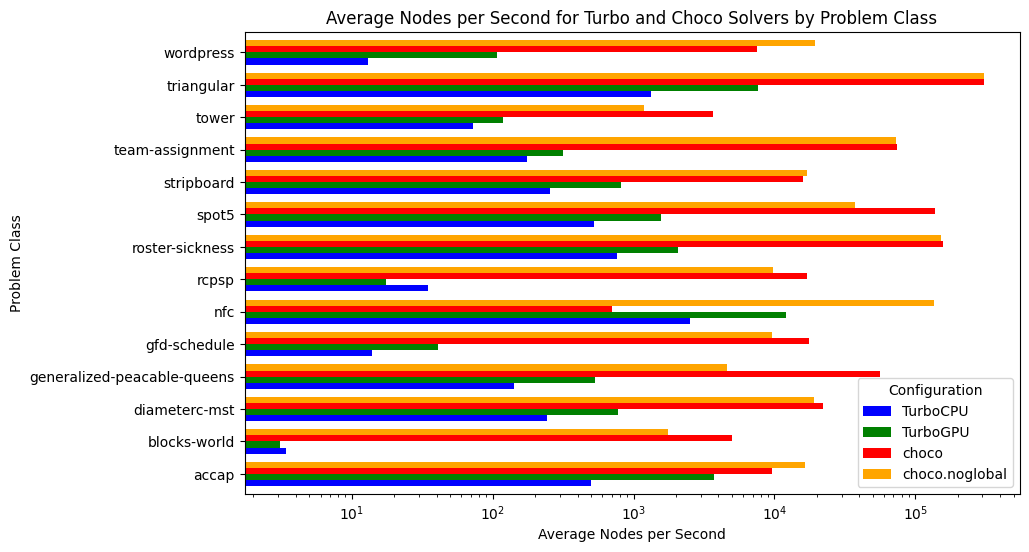

In [2]:
# Filter rows where configuration starts with "Turbo"
solvers = all_xp[~all_xp['configuration'].str.startswith("or-tools")].copy()

# Calculate nodes per second and add it as a new column
solvers['nodes_per_second'] = solvers['nodes'] / solvers['solveTime']

# Group by 'problem' and 'configuration', then calculate the average nodes per second
grouped = solvers.groupby(['problem', 'configuration'])['nodes_per_second'].mean()

# Reshape for plotting
unstacked = grouped.unstack()

# Plotting
colors = ['blue', 'green', 'red', 'orange', 'yellow']
unstacked.plot(kind='barh', figsize=(10, 6), color=colors, width=0.75, logx=True)
plt.xlabel('Average Nodes per Second')
plt.ylabel('Problem Class')
plt.title('Average Nodes per Second for Turbo and Choco Solvers by Problem Class')
plt.legend(title='Configuration')
plt.show()

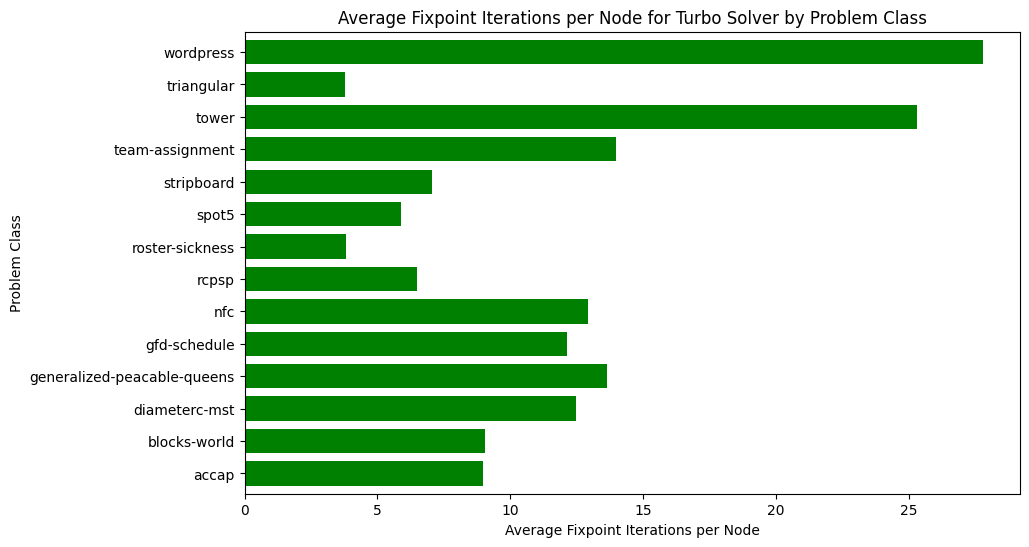

In [3]:
# Filter rows where configuration starts with "Turbo"
turbo_df = all_xp[all_xp['configuration'] == "TurboGPU"].copy()

# Calculate FP iterations per nodes and add it as a new column
turbo_df['fp_iterations_per_node'] = turbo_df['fixpoint_iterations'] / turbo_df['nodes']

# Group by 'problem' then calculate the average nodes per second
grouped = turbo_df.groupby(['problem'])['fp_iterations_per_node'].mean()

# Plotting
colors = ['green']
grouped.plot(kind='barh', figsize=(10, 6), color=colors, width=0.75)
plt.xlabel('Average Fixpoint Iterations per Node')
plt.ylabel('Problem Class')
plt.title('Average Fixpoint Iterations per Node for Turbo Solver by Problem Class')
# plt.legend(title='Configuration')
plt.show()

We want to compare the obtained objective value of TurboCPU and TurboGPU. Draw a pie chart where one part represents the percentage of the problems where the objective value found by TurboCPU is better, one part where the objective value found by TurboGPU is better, and another part when they are equal.

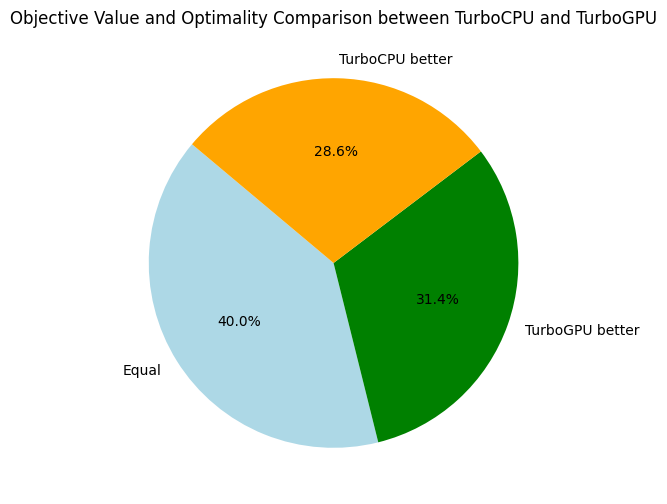

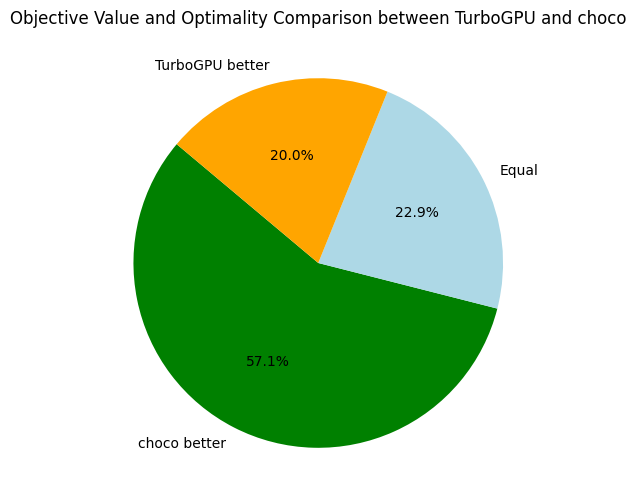

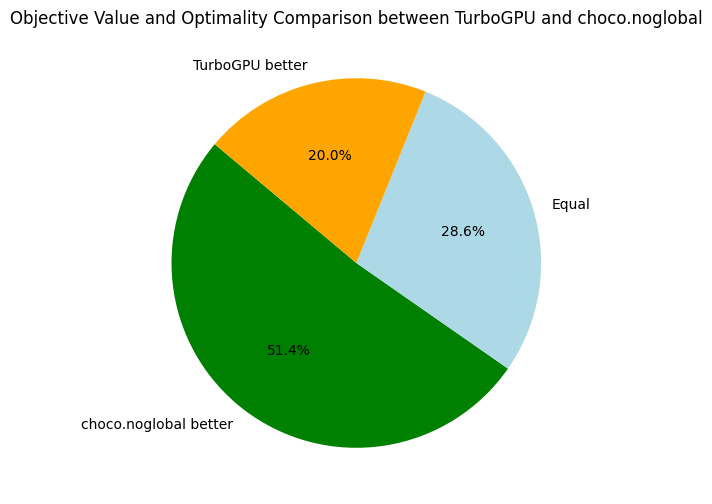

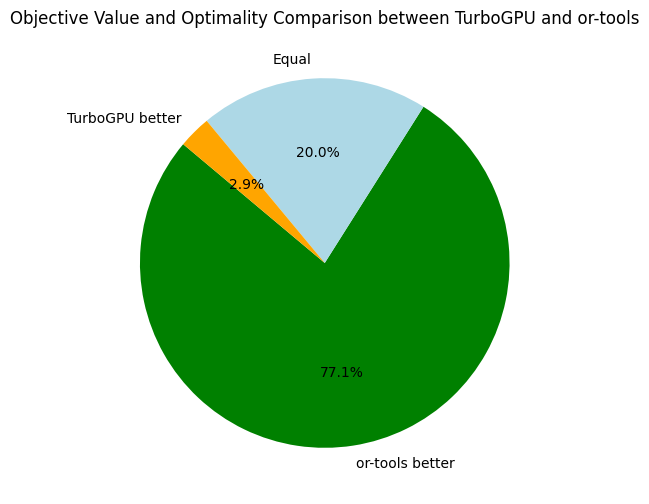

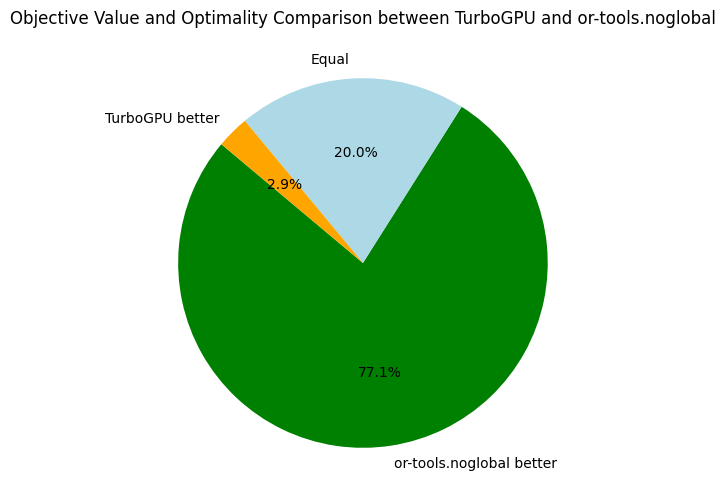

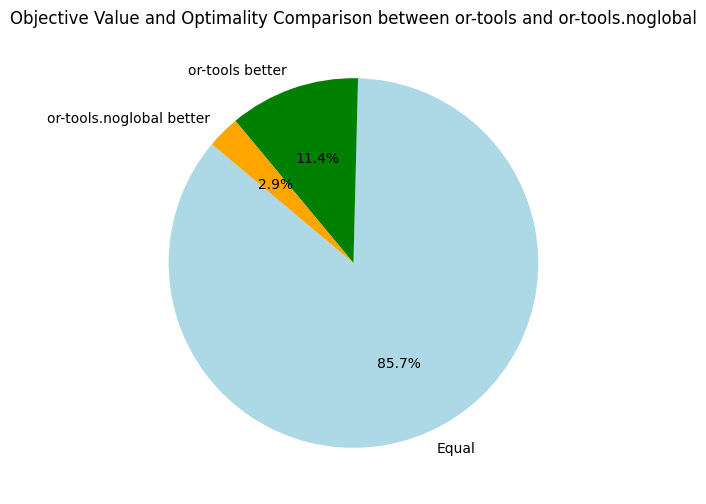

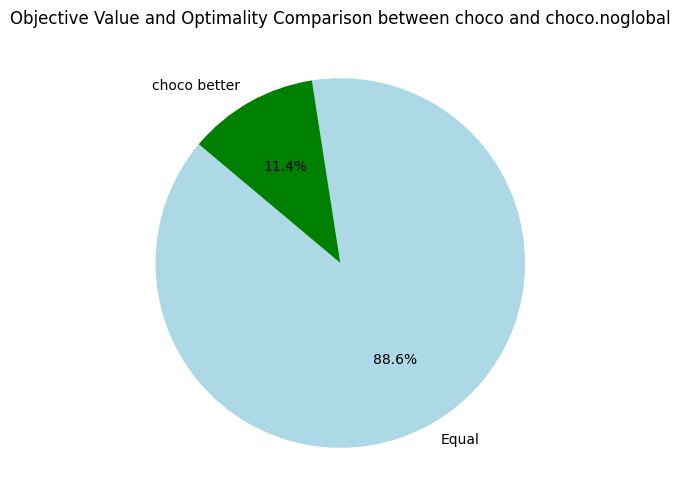

In [4]:
def compare_solvers_pie_chart(df, solver1, solver2):
    """
    Compares the performance of two solvers based on objective value and optimality.

    Parameters:
    - df: DataFrame containing the data.
    - solver1: Name of the first solver (str).
    - solver2: Name of the second solver (str).

    Returns:
    - Displays a pie chart comparing the performance of the two solvers.
    """

    solvers_df = df[(df['configuration'] == solver1) | (df['configuration'] == solver2)]

    # Pivoting for 'objective', 'method', and 'status' columns
    pivot_df = solvers_df.pivot_table(index='data_file', columns='configuration', values=['objective', 'method', 'status'], aggfunc='first')

    # Compare objective values based on method and optimality status
    conditions = [
        # Error
        (pivot_df['method', solver1] != pivot_df['method', solver2]),

        # Solver 1 better
        ((pivot_df['status', solver1] != "UNKNOWN") & (pivot_df['status', solver2] == "UNKNOWN")) |
        ((pivot_df['method', solver1] == "minimize") & (pivot_df['objective', solver1] < pivot_df['objective', solver2])) |
        ((pivot_df['method', solver1] == "maximize") & (pivot_df['objective', solver1] > pivot_df['objective', solver2])) |
        ((pivot_df['objective', solver1] == pivot_df['objective', solver2]) & (pivot_df['status', solver1] == "OPTIMAL_SOLUTION") & (pivot_df['status', solver2] != "OPTIMAL_SOLUTION")),

        # Solver 2 better
        ((pivot_df['status', solver1] == "UNKNOWN") & (pivot_df['status', solver2] != "UNKNOWN")) |
        ((pivot_df['method', solver1] == "minimize") & (pivot_df['objective', solver1] > pivot_df['objective', solver2])) |
        ((pivot_df['method', solver1] == "maximize") & (pivot_df['objective', solver1] < pivot_df['objective', solver2])) |
        ((pivot_df['objective', solver1] == pivot_df['objective', solver2]) & (pivot_df['status', solver1] != "OPTIMAL_SOLUTION") & (pivot_df['status', solver2] == "OPTIMAL_SOLUTION")),

        # Equal
        (pivot_df['status', solver1] == pivot_df['status', solver2])
    ]

    choices = ['Error', f'{solver1} better', f'{solver2} better', 'Equal']

    pivot_df['Comparison'] = np.select(conditions, choices, default='Unknown')

    # Get problems with "Unknown" comparison (should not happen, this is for debugging).
    # unknown_problems = pivot_df[pivot_df['Comparison'] == 'Unknown'].index.tolist()
    # if unknown_problems:
    #     print(f"The comparison is 'Unknown' for the following problems: {', '.join(unknown_problems)}")
    # else:
    #     print("There are no problems with 'Unknown' comparison.")

    # Get counts for each category
    category_counts = pivot_df['Comparison'].value_counts()

    color_mapping = {
        f'{solver1} better': 'green' if category_counts.get(f'{solver1} better', 0) >= category_counts.get(f'{solver2} better', 0) else 'orange',
        f'{solver2} better': 'green' if category_counts.get(f'{solver2} better', 0) > category_counts.get(f'{solver1} better', 0) else 'orange',
        'Equal': (0.678, 0.847, 0.902), # light blue
        'Unknown': 'red',
        'Error': 'red'
    }
    colors = [color_mapping[cat] for cat in category_counts.index]

    # Plot pie chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f'Objective Value and Optimality Comparison between {solver1} and {solver2}')
    plt.ylabel('')
    plt.show()

    return pivot_df

compare_solvers_pie_chart(all_xp, "TurboCPU", "TurboGPU")
compare_solvers_pie_chart(all_xp, "TurboGPU", "choco")
compare_solvers_pie_chart(all_xp, "TurboGPU", "choco.noglobal")
r = compare_solvers_pie_chart(all_xp, "TurboGPU", "or-tools")
# r[r['Comparison'] == f'TurboGPU better'].to_csv('out.csv')
_ = compare_solvers_pie_chart(all_xp, "TurboGPU", "or-tools.noglobal")
_ = compare_solvers_pie_chart(all_xp, "or-tools", "or-tools.noglobal")
_ = compare_solvers_pie_chart(all_xp, "choco", "choco.noglobal")

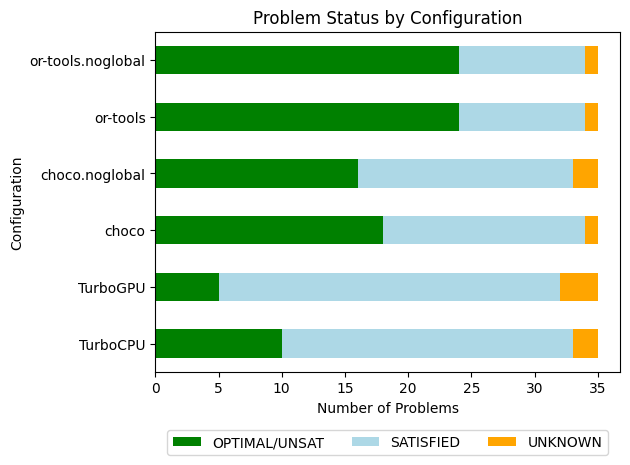

In [5]:
grouped = all_xp.groupby(['configuration', 'status']).size().unstack(fill_value=0)
grouped['OPTIMAL/UNSAT'] = grouped.get('OPTIMAL_SOLUTION', 0) + grouped.get('UNSATISFIABLE', 0)

grouped = grouped[['OPTIMAL/UNSAT', 'SATISFIED', 'UNKNOWN']]

# Plot
colors = {'OPTIMAL/UNSAT': 'green', 'SATISFIED': 'lightblue', 'UNKNOWN': 'orange'}
ax = grouped.plot(kind='barh', stacked=True, color=[colors[col] for col in grouped.columns])
plt.title('Problem Status by Configuration')
plt.ylabel('Configuration')
plt.xlabel('Number of Problems')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()

In [6]:
# Filter for TurboGPU solver
turbo_gpu_df = all_xp[all_xp['configuration'] == 'TurboGPU'].copy()

turbo_gpu_df['nodes_per_second'] = turbo_gpu_df['nodes'] / turbo_gpu_df['solveTime']
turbo_gpu_df['fp_iterations_per_node'] = turbo_gpu_df['fixpoint_iterations'] / turbo_gpu_df['nodes']

avg_nodes_per_second = turbo_gpu_df['nodes_per_second'].mean()
avg_fp_iterations = turbo_gpu_df['fp_iterations_per_node'].mean()
median_nodes_per_second = turbo_gpu_df['nodes_per_second'].median()
median_fp_iterations = turbo_gpu_df['fp_iterations_per_node'].median()

# Count problems with non-zero num_blocks_done and not solved to optimality or proven unsatisfiable
condition = (turbo_gpu_df['num_blocks_done'] != 0) & (~turbo_gpu_df['status'].isin(['OPTIMAL_SOLUTION', 'UNSATISFIABLE']))
count_problems = turbo_gpu_df[condition].shape[0]

avg_propagator_mem_mb = turbo_gpu_df['propagator_mem'].mean() / 1000 / 1000
avg_store_mem_kb = turbo_gpu_df['store_mem'].mean() / 1000

median_propagator_mem_mb = turbo_gpu_df['propagator_mem'].median() / 1000 / 1000
median_store_mem_kb = turbo_gpu_df['store_mem'].median() / 1000

# Print results
print(f"Average nodes per second for TurboGPU: {avg_nodes_per_second:.2f} (median = {median_nodes_per_second:.2f})")
print(f"Average ratio of fixpoint_iterations to nodes for TurboGPU: {avg_fp_iterations:.2f} (median = {median_fp_iterations:.2f})")
print(f"Number of problems with non-zero num_blocks_done and not optimal/unsatisfiable: {count_problems}")
print(f"Average propagator_mem for TurboGPU across all data_files: {avg_propagator_mem_mb:.2f} MB  (median = {median_propagator_mem_mb:.2f} MB)")
print(f"Average store_mem for TurboGPU across all data_files: {avg_store_mem_kb:.2f} KB (median = {median_store_mem_kb:.2f} KB)")

Average nodes per second for TurboGPU: 1246.77 (median = 35.07)
Average ratio of fixpoint_iterations to nodes for TurboGPU: 8.48 (median = 7.11)
Number of problems with non-zero num_blocks_done and not optimal/unsatisfiable: 13
Average propagator_mem for TurboGPU across all data_files: 16.41 MB  (median = 13.07 MB)
Average store_mem for TurboGPU across all data_files: 167.78 KB (median = 174.01 KB)


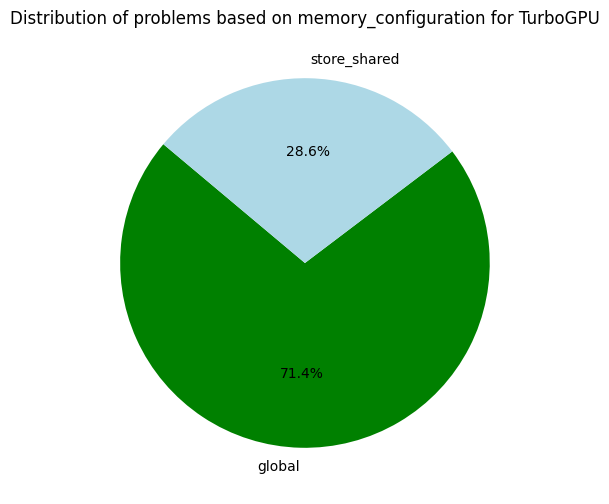

In [7]:
# Filter for TurboGPU solver
turbo_gpu_df = all_xp[all_xp['configuration'] == 'TurboGPU']

# Count the occurrences of each memory_configuration
memory_config_counts = turbo_gpu_df['memory_configuration'].value_counts()

# Plot the pie chart
colors = ['green', 'lightblue', 'orange', 'lightcoral', 'purple']  # Adjust as needed
plt.figure(figsize=(10, 6))
memory_config_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of problems based on memory_configuration for TurboGPU')
plt.ylabel('')  # To remove the default 'memory_configuration' ylabel
plt.show()

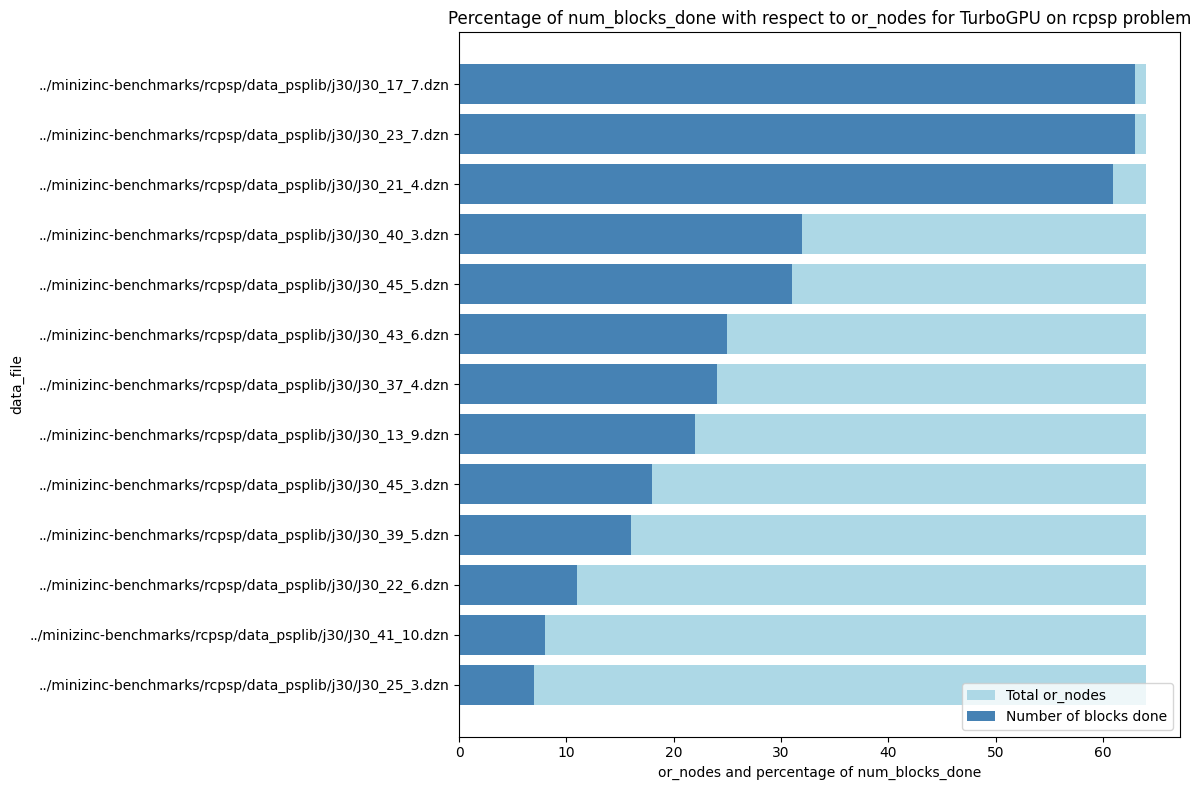

In [8]:
# Filter rows for TurboGPU, rcpsp, num_blocks_done > 0 and not solved to optimality
filtered_df = turbo_df[(turbo_df['configuration'] == 'TurboGPU') &
                       (turbo_df['problem'] == 'rcpsp') &
                       (turbo_df['num_blocks_done'] > 0) &
                       ~turbo_df['status'].isin(['OPTIMAL_SOLUTION', 'UNSATISFIABLE'])].copy()

# Sorting the dataframe for better visualization
sorted_df = filtered_df.sort_values(by='num_blocks_done', ascending=True)

# Plotting the data
plt.figure(figsize=(12, 8))

# Plotting or_nodes (full bar)
plt.barh(sorted_df['data_file'], sorted_df['or_nodes'], color='lightblue', label='Total or_nodes')

# Plotting num_blocks_done (part of the bar)
plt.barh(sorted_df['data_file'], sorted_df['num_blocks_done'], color='steelblue', label='Number of blocks done')

plt.xlabel('or_nodes and percentage of num_blocks_done')
plt.ylabel('data_file')
plt.title('Percentage of num_blocks_done with respect to or_nodes for TurboGPU on rcpsp problem')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

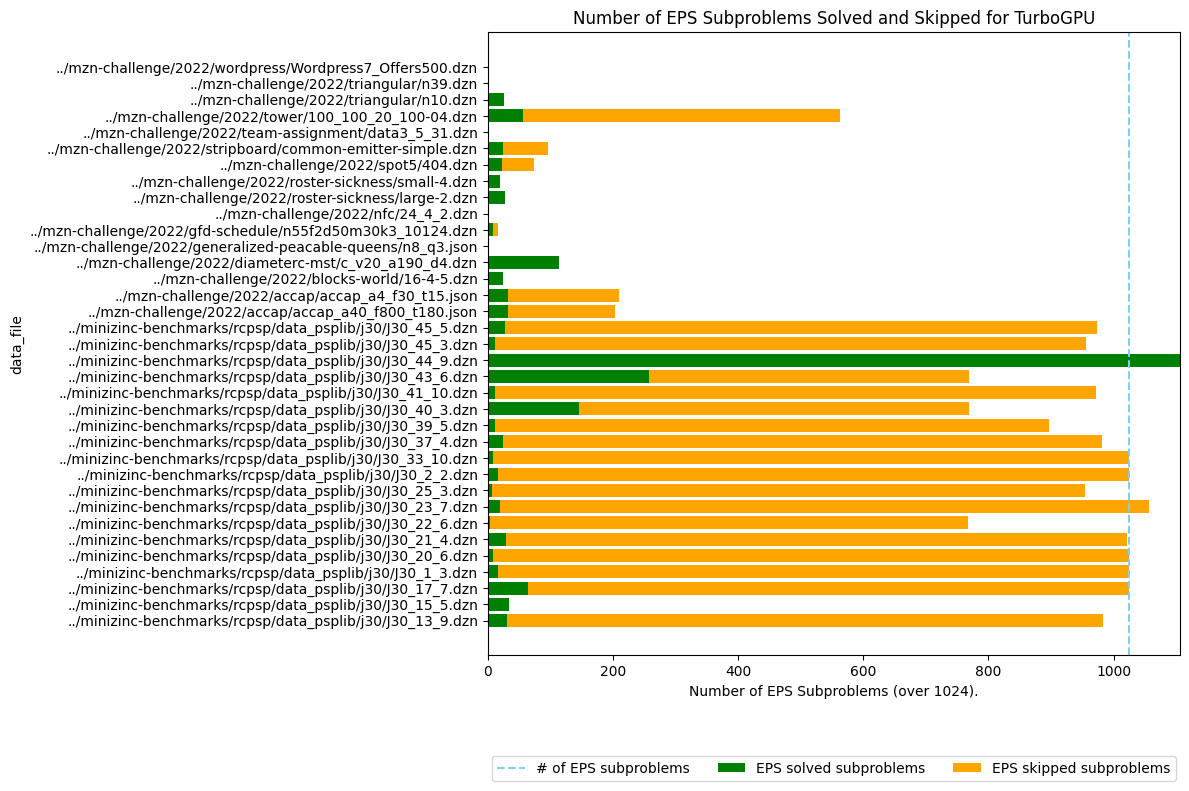

In [9]:
# Filter rows for TurboGPU
filtered_df = all_xp[all_xp['configuration'] == 'TurboGPU'].copy()

number_of_subproblems = filtered_df['eps_num_subproblems'].unique()
assert(len(number_of_subproblems) == 1)
number_of_subproblems = number_of_subproblems[0]

# Sorting the dataframe for better visualization
sorted_df = filtered_df.sort_values(by='data_file')

# Plotting the data
plt.figure(figsize=(12, 8))

# Plotting solved proportion
plt.barh(sorted_df['data_file'], sorted_df['eps_solved_subproblems'], color='green', label='EPS solved subproblems')

# Plotting skipped proportion, stacked on top of solved proportion
plt.barh(sorted_df['data_file'], sorted_df['eps_skipped_subproblems'], left=sorted_df['eps_solved_subproblems'], color='orange', label='EPS skipped subproblems')

plt.axvline(x=number_of_subproblems, color='skyblue', linestyle='--', label='# of EPS subproblems')

plt.xlabel(f'Number of EPS Subproblems (over {number_of_subproblems}).')
plt.ylabel('data_file')
plt.title('Number of EPS Subproblems Solved and Skipped for TurboGPU')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()